In [2]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make("LunarLander-v3",render_mode="rgb_array")

In [4]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [5]:
obs, info = env.reset(seed = 42)
obs

array([ 0.00229702,  1.4181306 ,  0.23264714,  0.32046658, -0.00265488,
       -0.05269808,  0.        ,  0.        ], dtype=float32)

In [6]:
env.action_space

Discrete(4)

In [7]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(n_outputs,activation="softmax")
    
])


In [8]:
probas = tf.constant([0.1,0.2,0.6,0.1],dtype=tf.float32)
logits = tf.math.log(probas + tf.keras.backend.epsilon())
logits = tf.expand_dims(logits, axis=0) 

In [9]:
logits

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-2.3025842, -1.6094373, -0.5108254, -2.3025842]], dtype=float32)>

In [10]:
action = tf.random.categorical(logits,num_samples=1)

In [11]:
action

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>

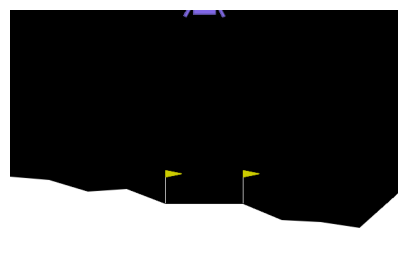

In [12]:
def plot_environment(env):
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
plt.figure(figsize=(5,5))
plot_environment(env)

In [13]:
obs,info = env.reset()

In [14]:
action = 0
obs,reward,done,truncated,info = env.step(action)

In [15]:
obs

array([-0.01103888,  1.4180024 , -0.55829865,  0.14451218,  0.01265977,
        0.12516338,  0.        ,  0.        ], dtype=float32)

In [16]:
reward

-0.1850250936617499

In [17]:
done

False

In [18]:
truncated

False

In [19]:
info

{}

In [20]:
def lander_play_one_step(env,obs,model,loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits,num_samples=1)
        loss = tf.reduce_mean(loss_fn(action,probas))
                              
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(action[0,0].numpy())
    return obs, reward, done, truncated, grads


In [21]:
def lander_play_multiple_episodes(env,model,n_episodes,n_steps,loss_fn):
    all_grads = []
    all_rewards = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs,info = env.reset()
        for step in range(n_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(env, obs, model,
                                                                     loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_grads, all_rewards        

In [22]:
def discounted_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2 , -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

In [23]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discounted_rewards(rewards,discount_factor)
                             for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
           for discounted_rewards in all_discounted_rewards]

In [24]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_factor = 0.99

In [25]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

In [26]:
env.reset()
mean_rewards = []

for iteration in range(n_iterations):
    all_grads , all_rewards = lander_play_multiple_episodes(env,model,n_episodes_per_update,
                                                            n_max_steps,loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean reward: {mean_reward:.1f}  ", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 110.1  

In [ ]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [51]:
def lander_render(model,n_max_steps=500,seed=42):
    frames = []
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, n_samples=1)
        obs, reward, done, truncated, info = env.step(action[0,0].numpy())
        if done or truncated:
            break
    env.close()
    return frames
    

In [ ]:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
frames = lander_render(model)
plot_animation(frames)